In [470]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import print_function

"""
Simulate navigation along a road graph
Each episode is:
- a navigation from a random start point to a random end point
 - OR -
- a reward of [some negative score]
whichever comes first

The agent is presented with the following 7 actions:
 - Go straight
 - Make slight right turn
 - Make slight left turn
 - Make right turn
 - Make left turn
 - Make hard right turn
 - Make hard left turn
 - Make U-Turn

"""

import gym
from gym import error, spaces, utils
from gym.utils import seeding
import random
import math
import networkx
import matplotlib.pyplot as plt
import json
from math import sin, cos, radians, pi
from matplotlib import collections  as mc
import matplotlib.lines as mlines
import osmnx as ox
from pprint import pprint
import pyproj



print( "imported libraries")

def loadGraph(filename):
    G = networkx.read_gpickle(filename)
    for node in G.nodes:
        nodeAttr = G.node[node]
        G.node[node]['p'] = (nodeAttr['x'], nodeAttr['y'])
    return G.to_undirected()



class GraphEnv(gym.Env):
    """
        Define a simple navigation environment.
    """

    metadata = {'render.modes': ['human']}

    def __init__(self, world, isStatic=False, start_node=None, facing=0, target_node=None, HOPS=5):
        self.__version__ = "0.1.0"
        print("Navigation Environment - {} - Version {}".format(world, self.__version__))

        self.current_episode = 0
        self.current_step = 0

        self.action_space = spaces.Discrete(7) ## seven available turn actions

        self.observation_space = spaces.Discrete(2) ## observations are an 8-length vector

        self.action_dict = {
            "STRAIGHT": 0,
            "SLIGHT_LEFT": 1,
            "LEFT": 2,
            "HARD_LEFT": 3,
            "U-TURN": 4,
            "HARD_RIGHT": 5,
            "RIGHT": 6,
            "SLIGHT_RIGHT": 7
        }

        self.actions_list = list(self.action_dict.keys())
        self.world = world
        self.graph = self.getWorldGraph(world)
        self.staticEnv = isStatic
        self.start_node = start_node
        self.target_node = target_node
        self.HOPS = HOPS
        self.facing = facing 
        self.centrality = networkx.betweenness_centrality(self.graph)
        self.figure = plt.figure()

    def getWorldGraph(self, world):
        ## TODO: the graph should come from the real world here
        simpleGraph = loadGraph(world)
        return simpleGraph

    def step(self, action):
        """
        The agent takes a step in the environment.
        Parameters
        ----------
        action : int
        Returns
        -------
        ob, reward, episode_over, info : tuple
            ob (object) :
                an environment-specific object representing your observation of
                the environment.
            reward (float) :
                amount of reward achieved by the previous action. The scale
                varies between environments, but the goal is always to increase
                your total reward.
            episode_over (bool) :
                whether it's time to reset the environment again. Most (but not
                all) tasks are divided up into well-defined episodes, and done
                being True indicates the episode has terminated. (For example,
                perhaps the pole tipped too far, or you lost your last life.)
            info (dict) :
                 diagnostic information useful for debugging. It can sometimes
                 be useful for learning (for example, it might contain the raw
                 probabilities behind the environment's last state change).
                 However, official evaluations of your agent are not allowed to
                 use this for learning.
        """
        self.current_step += 1
        self._take_action(action)
        reward = self._get_reward()
        self.cum_reward += reward
        ob = self._get_state()
        done = self._is_episode_finished()
        return ob, reward, done, {}

    def reset(self):
        print ("Environment reset for episode " , self.current_episode)
        if not self.staticEnv: ## objective is different on every episode
            self.start_node = random.choice(list(self.graph.nodes))
            self.target_node = self.get_target_node(self.start_node, self.HOPS)
            self.facing = random.choice(range(0, 360)) ## random start angle
        ## else, the environment graph + start + target nodes are always the same
        assert self.start_node is not None
        assert self.target_node is not None
        assert self.graph is not None
        self.current_episode += 1
        self.current_step = 0
        self.current_node = self.start_node
        self.start_position = self.graph.node[self.start_node]['p']
        self.end_position = self.graph.node[self.target_node]['p']
        self.neighbors = self.getConnections(self.start_node)
        self.x = self.start_position[0]
        self.y = self.start_position[1]
        self.actions = self.getActions()
        self.history = []
        self.last_distance_travelled = 0
        self.action_blocked = False
        self.cum_reward = 0
        self.last_action =  None

        self.distance_traveled = 0
        self.geo_distance_to_goal = self.getGeoDistance(self.start_position, self.end_position)
        self.ellipsoid = pyproj.Geod(ellps='WGS84')


        return self._get_state()

    def get_target_node(self, start_node, hops):
        current_node = start_node
        for i in range(0, hops):
            choices = list(self.graph.neighbors(current_node))
            if (len(choices) == 0):
                continue
            next_node = random.choice(choices)
            current_node = next_node
        return current_node

    def render(self, mode='human', close=False, labels=False):
        fig = plt.figure(figsize=(10, 10))
        nodes = list(self.graph.nodes)
        pts = []
        labs = []
        for n in nodes:
            nodeInfo = self.graph.node[n]
            pts.append(nodeInfo['p'])
            labs.append(n)
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]

        ## labels
        if False:
            for i in range(0, len(labs)):
                fig.text(xs[i], ys[i], labs[i])

        plt.title("action = {} blocked = {}".format(self.last_action, self.action_blocked))

        ## path history
        for segment in self.history:
            ax = fig.gca()
            _x = (segment[0][0], segment[1][0])
            _y = (segment[0][1], segment[1][1])

            l = mlines.Line2D(_x, _y)

            ax.add_line(l)

        ## connected paths
        for node in self.graph.nodes:

            _source = self.graph.node[node]['p']
            _targets = self.graph.neighbors(node)
            for t in _targets:
                _target = self.graph.node[t]['p']

                ax = fig.gca()
                _x = (_source[0], _target[0])
                _y = (_source[1], _target[1])

                l = mlines.Line2D(_x, _y, color='gray')
                ax.add_line(l)

        ## node points
        plt.scatter(xs, ys, color='gray')

        
        plt.plot([self.end_position[0]], [self.end_position[1]], 'ro',  color='blue',markersize=12, zorder=10)
        plt.plot([self.x], [self.y], 'ro',  color='red',markersize=12, zorder=10)



    # def angleToPos(self, theta, x0, y0, d=0.001):
    #     theta_rad = radians(theta)
    #     x1 = (x0 - d*cos(theta_rad))
    #     y1 = (y0 - d*sin(theta_rad))
    #     return x1, y1

    def getNodeXY(self, node):
        return self.graph.node[node]["p"]

    def bearing(self, A, B):
        lat1 = math.radians(A[1])
        lat2 = math.radians(B[1])

        diffLong = math.radians(B[0] - A[0])

        x = math.sin(diffLong) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
                * math.cos(lat2) * math.cos(diffLong))

        initial_bearing = math.atan2(x, y)
        return self.normalize_angle(math.degrees(initial_bearing))

    def getAngleToNextNode(self, nodeA, nodeB, current_heading):
        posA = self.getNodeXY(nodeA)
        posB = self.getNodeXY(nodeB)
        geo_bearing = self.bearing(posA, posB)
        heading2node = (geo_bearing - current_heading);
        next_heading = self.normalize_angle(heading2node)

        return round(next_heading)

    def getAnglesToNeighbors(self, node, referenceAngle):
        angles = []
        neighbors = self.graph.neighbors(node)

        for n in neighbors:
            d = self.normalize_angle(self.getAngleToNextNode(node, n, referenceAngle))
            angles.append(d)
        return angles

    def actionFromAngle(self, angle):
        angle = abs(angle)
        if angle == 0 or angle == 360:
            return "STRAIGHT"
        elif angle < 60:
            return "SLIGHT_RIGHT"
        elif angle < 120:
            return "RIGHT"
        elif angle < 180:
            return "HARD_RIGHT"
        elif angle == 180:
            return "U_TURN"
        elif angle < 240:
            return "HARD_LEFT"
        elif angle < 300:
            return "LEFT"
        elif angle < 360:
            return "SLIGHT_LEFT"
        else:
            raise ValueError("INVALID ANGLE")
        # if angle == 0:
        #     return "STRAIGHT"
        # elif angle < 0 and angle > -60:
        #     return "SLIGHT_LEFT"
        # elif angle <= -60 and angle > -120:
        #     return "LEFT"
        # elif angle <= -120 and angle > -180:
        #     return "HARD_LEFT"
        # elif angle == 180 or angle == -180:
        #     return "U_TURN"
        # elif angle < 60 and angle > 0:
        #     return "SLIGHT_RIGHT"
        # elif angle >= 60 and angle < 120:
        #     return "RIGHT"
        # elif angle >= 120 and angle < -180:
        #     return "HARD_RIGHT"
        # else:
        #     raise ValueError("invalid angle")


    def getConnections(self, node):
        self.graph[node].keys()
        return list(self.graph.neighbors(node))

    def getGeoDistance(self, node1, node2):
        return math.hypot(node2[0] - node2[0], node2[1] - node1[1])

    def _take_action(self,action):
        self.actions = self.getActions()
        thisAction = self.actions[action]
        destination = thisAction['destination']
        angle = thisAction['angle']

        self.last_action = thisAction['action']
        if destination is None: ## there are no connections given this action
            self.action_blocked = True
            return ## don't do anything
        else: ## connection is possible, go there
            self.action_blocked = False
            self.move_to_node(destination, angle)

    def _get_reward(self):
        if self.current_node == self.target_node:
            return 10000
        if self.action_blocked:
            return -1000
        else:
            return 5

    def _get_state(self):
        ## state obsveration space at node N
        ## - total geographic distance traveled from start_node
        ## - total navigated distance travlled from start_node
        ## - geographic distance remaining to target_node
        ## - angle to target_node
        ## - number of neighbors
        ## - for each possible action:
        ##  - distance to next node
        ##  - angle to next node
        ##  - highway class of edge to next node
        ##  - edge to next node is oneway
        ## later:
        ## - time of day
        ## - hourly traffic volume
        # angle_to_goal = self.bearing(self.current_node['p'], self.target_node['p'])
        angle_to_goal = 0
        geoDistanceTravelled = self.getGeoDistance(self.start_position, [self.x, self.y])
        navigatedDistance = self.distance_traveled
        distanceToGoal = self.geo_distance_to_goal
        numNeighbors = len(list(self.graph.neighbors(self.current_node)))
        nextAttrs = []
        actions = self.getActions()
        for action in actions:
            destination = action['destination']
            action_obs = self.get_edge_obs(self.current_node, destination)
            angle = action['angle']
            if angle is None:
                angle = -181
            action_obs.append(angle)
            nextAttrs = nextAttrs + action_obs
        return [self.facing, angle_to_goal, geoDistanceTravelled, navigatedDistance, distanceToGoal, numNeighbors] + nextAttrs

    def get_edge_obs(self, nodeA, nodeB):
        ##  - distance to next node
        ##  - angle to next node
        ##  - highway class of edge to next node
        ##  - edge to next node is oneway
        edge = self.graph.get_edge_data(nodeA, nodeB, 0)
        attrs = []
        if edge is not None:
            try:
                distance = edge['length'];
            except:
                distance = -1
            try:
                highway = self.highwayClass2Number(edge['highway']);
            except:
                highway = -1
            # try:
            #     oneway = int(edge['oneway']);
            # except:
            #     oneway = False
            bc = self.centrality[nodeB]
            attrs = attrs + [distance, highway, bc]
        else:
            attrs = attrs + [-1, -1, -1]
        return attrs


    def _is_episode_finished(self):
        if  self.current_node == self.target_node:
            print ("\nreached goal!\n")
            raise ValueError("end of episode")
            return True
        elif self.cum_reward < -10000:
            return True
        else:
            return False
        
        
        
    def move_to_node(self, node, facing):
        _node = self.current_node
        self.current_node = node
        geoPos = self.graph.node[node]['p']
        self.x = geoPos[0]
        self.y = geoPos[1]
        _lastXY = self.graph.node[_node]['p']
        
        _facing = self.facing
        self.facing =  self.getAngleToNextNode(_node, node, self.facing)
        print ("updated facing from ", _facing, " to ", self.facing)
        self.neighbors = self.getConnections(self.current_node)
        self.actions = self.getActions()

        
        _lastDistance = self.getGeoDistance(_lastXY, geoPos)
        self.last_distance_travelled = _lastDistance

        self.history.append([_lastXY, geoPos])
        self.distance_traveled += _lastDistance
        self.geo_distance_to_goal = self.getGeoDistance(geoPos, self.end_position)

        return

    def highwayClass2Number(self, classification):
        if classification == "motorway":
            return 75
        elif classification == "trunk":
            return 60
        elif classification == "primary":
            return 50
        elif classification == "secondary":
            return 45
        elif classification == "tertiary":
            return 25
        elif classification == "residential":
            return 25
        else:
            return 5

    def getActions(self):
        _neighbors = self.getConnections(self.current_node)
        _connectionAngles = self.getAnglesToNeighbors(self.current_node, self.facing)
        _allowed_actions = [] ## reset
        for angle in _connectionAngles:
            action = self.actionFromAngle(int(angle)) ## okay
            _allowed_actions.append(action)

        _actions = []
        idx = 0
        o = 0
        for action in self.actions_list: ## iterate through all the actions the agent knows how to do
            ## TODO: calculate cost here for reward
            if action in _allowed_actions:

                result = {"destination" : _neighbors[idx], "angle": _connectionAngles[idx], "action": action, 'action_number': o}
                idx += 1
            else:
                result = {"destination": None, "angle": None, "action": action, 'action_number': o}
            _actions.append(result)
            o += 1
        return _actions

    def _moveToNode(self, nodeID):
        self.current_node  = nodeID
        self.x, self.y = self.getNodeXY(self.current_node)
        
        
    def normalize_angle(self, angle):
        return ((angle + 360) % 360) 

imported libraries


In [471]:
env = GraphEnv("./gym_graph/envs/simpleWorld.gpickle", isStatic=True,start_node=2351399563, facing=0, target_node=342548255)

Navigation Environment - ./gym_graph/envs/simpleWorld.gpickle - Version 0.1.0


<Figure size 432x288 with 0 Axes>

In [472]:
env.action_dict["LEFT"]

2

In [473]:
obs =env.reset()

Environment reset for episode  0


[{'action': 'STRAIGHT', 'action_number': 0, 'angle': None, 'destination': None},
 {'action': 'SLIGHT_LEFT',
  'action_number': 1,
  'angle': 351,
  'destination': 276546821},
 {'action': 'LEFT', 'action_number': 2, 'angle': None, 'destination': None},
 {'action': 'HARD_LEFT',
  'action_number': 3,
  'angle': None,
  'destination': None},
 {'action': 'U-TURN', 'action_number': 4, 'angle': None, 'destination': None},
 {'action': 'HARD_RIGHT',
  'action_number': 5,
  'angle': None,
  'destination': None},
 {'action': 'RIGHT',
  'action_number': 6,
  'angle': 81,
  'destination': 5352470014},
 {'action': 'SLIGHT_RIGHT',
  'action_number': 7,
  'angle': None,
  'destination': None}]


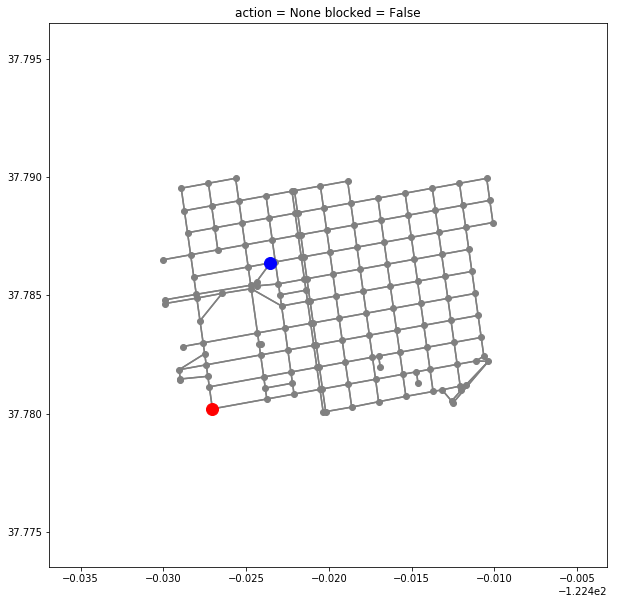

In [475]:
pprint(env.getActions())
# env.step(2)
env.render()

In [476]:
env.step(1)

updated facing from  0  to  351


([351,
  0,
  0.0009334000000009723,
  0.0009334000000009723,
  0.005246300000003146,
  3,
  105.101,
  25,
  0.0030143356913674892,
  180,
  -1,
  -1,
  -1,
  -181,
  -1,
  -1,
  -1,
  -181,
  -1,
  -1,
  -1,
  -181,
  -1,
  -1,
  -1,
  -181,
  -1,
  -1,
  -1,
  -181,
  50.242,
  25,
  0.014035426922491247,
  0,
  -1,
  -1,
  -1,
  -181],
 5,
 False,
 {})

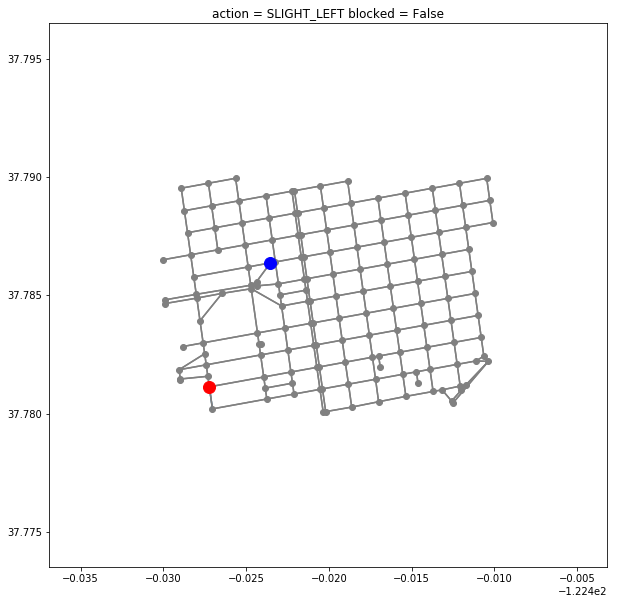

In [477]:
env.render()

In [481]:
pprint(env.getActions())

[{'action': 'STRAIGHT', 'action_number': 0, 'angle': None, 'destination': None},
 {'action': 'SLIGHT_LEFT',
  'action_number': 1,
  'angle': 351,
  'destination': 276546818},
 {'action': 'LEFT', 'action_number': 2, 'angle': 171, 'destination': 276546821},
 {'action': 'HARD_LEFT',
  'action_number': 3,
  'angle': None,
  'destination': None},
 {'action': 'U-TURN', 'action_number': 4, 'angle': None, 'destination': None},
 {'action': 'HARD_RIGHT',
  'action_number': 5,
  'angle': 265,
  'destination': 4018809930},
 {'action': 'RIGHT', 'action_number': 6, 'angle': None, 'destination': None},
 {'action': 'SLIGHT_RIGHT',
  'action_number': 7,
  'angle': None,
  'destination': None}]


In [482]:
env.step(1)

updated facing from  360  to  351


([351,
  0,
  0.0018652999999986264,
  0.0018652999999986264,
  0.004314400000005492,
  4,
  54.688,
  25,
  0.014035426922491247,
  180,
  -1,
  -1,
  -1,
  -181,
  52.854,
  25,
  0.01986572426311944,
  0,
  -1,
  -1,
  -1,
  -181,
  -1,
  -1,
  -1,
  -181,
  -1,
  -1,
  -1,
  -181,
  292.639,
  25,
  0.0682411761841875,
  90,
  -1,
  -1,
  -1,
  -181],
 5,
 False,
 {})

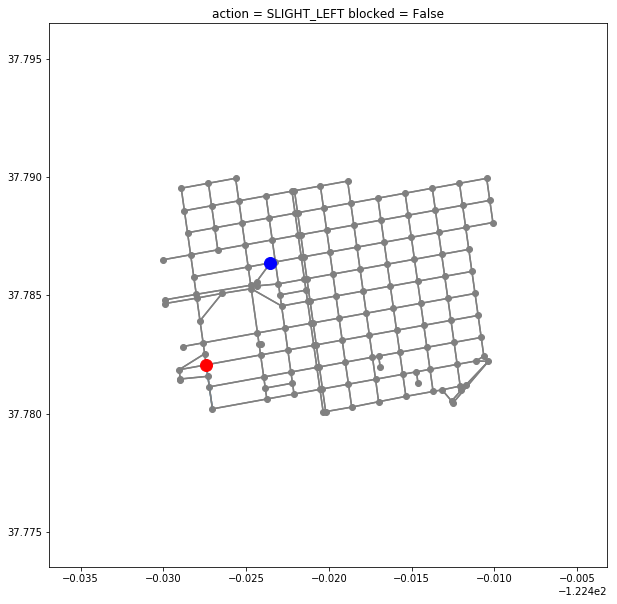

In [483]:
env.render()

In [383]:
env._moveToNode(65308268)

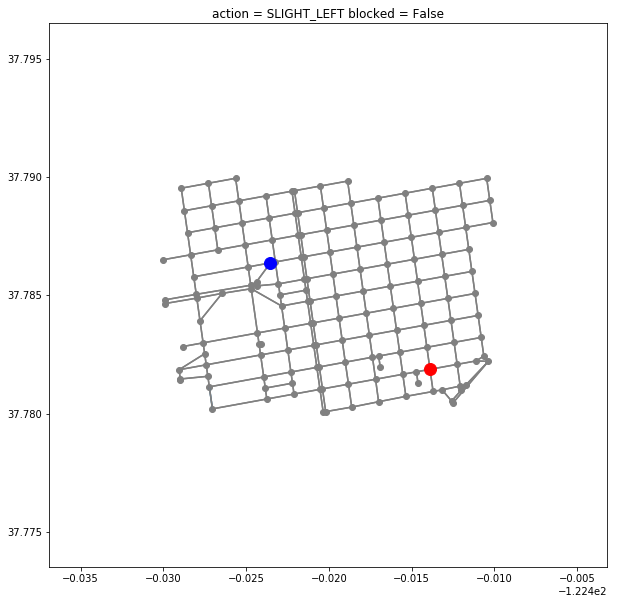

In [384]:
env.render()

In [385]:
n = env.getConnections(env.current_node)
initPos = env.getNodeXY(env.current_node)
for c in n:
    toPos = env.getNodeXY(c)
    print (c, "-->", env.bearing(initPos, toPos))

65362154 --> 350.94378401359177
65308264 --> 80.81865413547092
65308270 --> 260.8177604369587
65352325 --> 170.9439501777831


In [386]:
n

[65362154, 65308264, 65308270, 65352325]

In [192]:
import osmnx as ox
import matplotlib.pyplot as plt

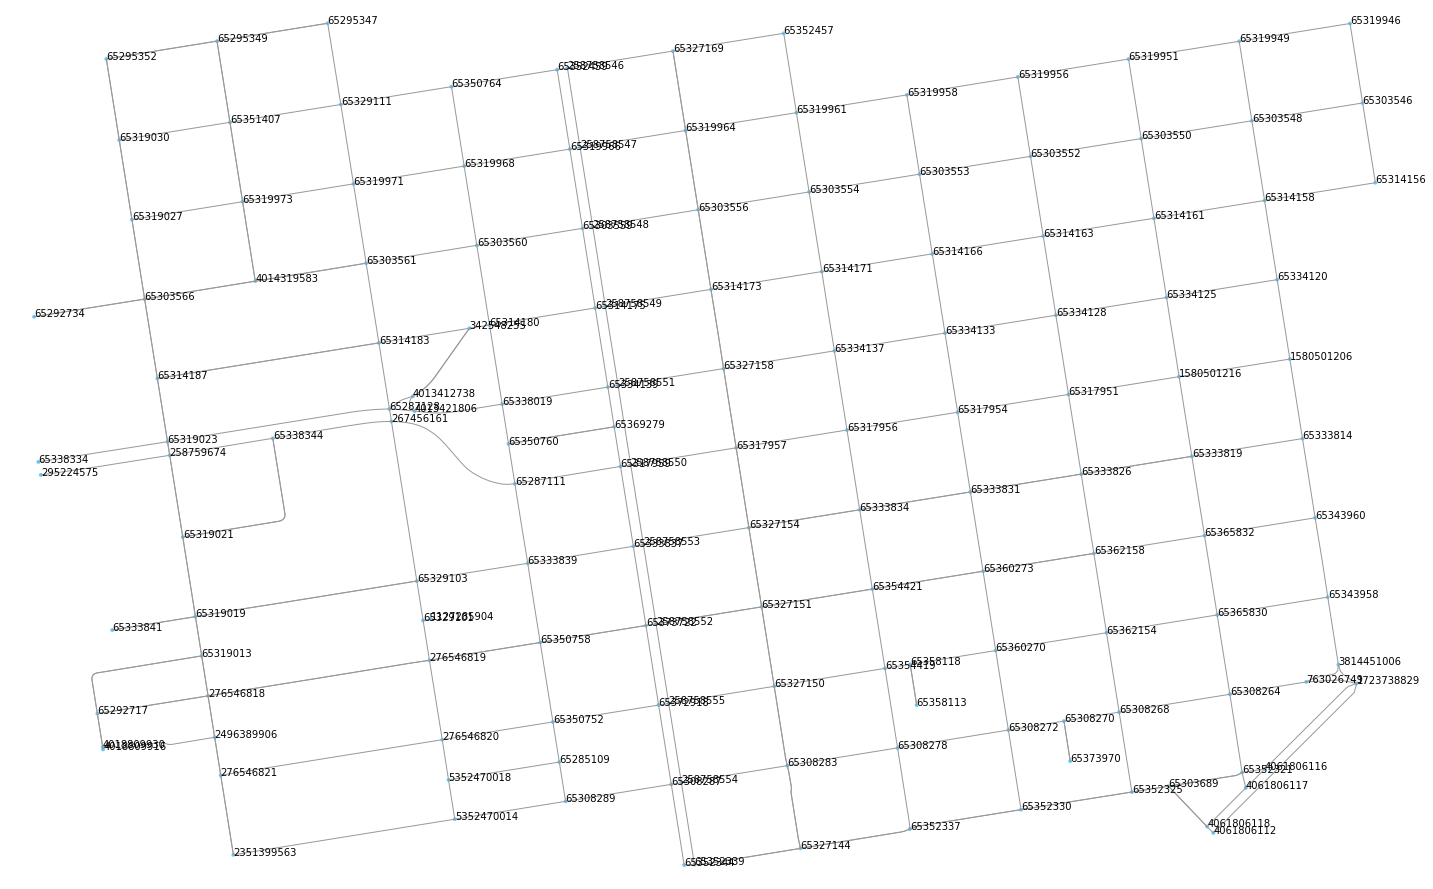

(<Figure size 1800x1800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117aeddd8>)

In [90]:
# plt.figure(figsize=(10,10))
ox.plot_graph(env.graph, annotate=True, fig_height=25, fig_width=25)